# Sobel Focus v2 Dev Notebook

In [139]:
import sys
from pathlib import Path
import pickle
import uuid
import cv2
import numpy as np
from rich import progress


path = Path("data")
im_files = [f for f in path.glob("*.png")]
ims = dict()
for f in progress.track(im_files, description="[green] Loading images"): 
    ims[int(f.stem)] = cv2.imread(str(f))


Output()

In [140]:
ims[0]

array([[[235, 235, 235],
        [235, 235, 235],
        [235, 235, 235],
        ...,
        [229, 229, 229],
        [229, 229, 229],
        [229, 229, 229]],

       [[235, 235, 235],
        [235, 235, 235],
        [235, 235, 235],
        ...,
        [229, 229, 229],
        [229, 229, 229],
        [229, 229, 229]],

       [[237, 237, 237],
        [237, 237, 237],
        [235, 235, 235],
        ...,
        [229, 229, 229],
        [229, 229, 229],
        [229, 229, 229]],

       ...,

       [[242, 242, 242],
        [242, 242, 242],
        [241, 241, 241],
        ...,
        [234, 234, 234],
        [234, 234, 234],
        [235, 235, 235]],

       [[242, 242, 242],
        [242, 242, 242],
        [241, 241, 241],
        ...,
        [234, 234, 234],
        [234, 234, 234],
        [235, 235, 235]],

       [[242, 242, 242],
        [242, 242, 242],
        [241, 241, 241],
        ...,
        [234, 234, 234],
        [234, 234, 234],
        [235, 235, 235]]

In [141]:
"""
safas/filters/sobel_focus

Sobel-focus image filter to identify flocs based on 
  threshold and edge gradient

"""
from copy import deepcopy
import uuid
import json

import cv2
import numpy as np

# NOTE: path hack to get relative import above top of package. to fix on install. 
from pathlib import Path
import sys
#path = str(Path(__file__).absolute().parents[2])
#sys.path.append(path) # Adds higher directory to python modules path.
#from prints import print_labeler as print

params = {
    "name": "kwargs", 
    "title": "Parameters",
    "type": "group", 
    "children": 
    [	
        {"name": "img_thresh", "title": "Intensity threshold", "type":  "int", "limits": [0, 255], "value": 120},
        {"name": "edge_thresh", "title": "Edge threshold", "type":  "int", "limits": [0, 255], "value": 30},
        {"name": "edge_distance", "title": "Edge distance", "type":  "int", "limits": [0, 9], "value": 1},
        {"name": "apply_focus_filter", "title": "Apply focus filter", "type":  "bool", "value": False},
        {"name": "thresh_inv", "title": "Inverse Threshold", "type":  "bool", "value": True},
        {"name": "add_images", "title": "Add images", "type":  "bool", "value": True},
        {"name": "area_min_px", "title": "Area Min. px", "type":  "int", "limits": [0, 500], "value": 5},
    # {"name": "update_settings", "title": "Update Settings", "type":  "action","value": None},
    ]
}

          
def setup(): return None
  
def labeler(src=None, 
            img_thresh=100, 
            edge_thresh=10, 
            edge_distance=1, 
            cal_contours=True,
            apply_focus_filter=True,
            add_imgs=True,
            area_min_px=5,
            thresh_inv=True,
            display=False, 
            frame_index=None,
            *args, **kwargs): 
    """ Filter 
    
    Returns
    ----------
    labels, array: label image array with int values indicating objects
    conn_comp: connected components analysis of label_img

    """
    if src.ndim == 3: 
        src_gs = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    else: 
        src_gs = deepcopy(src)

    src = cv2.GaussianBlur(src_gs, (3, 3), 0)
    if thresh_inv: # thresh_inv = True is brightfield, ie the objects are darker than the field
        ret, thresh = cv2.threshold(src_gs, img_thresh, 255, cv2.THRESH_BINARY_INV)
    else: 
        ret, thresh = cv2.threshold(src_gs, img_thresh, 0, cv2.THRESH_BINARY)

    _, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, 4, cv2.CV_32S)

    area = stats[:, 4]
    bbox = stats[:,:4]
    
    if display: print(f"frame {frame_index}: {len(stats)-1} objects detected")
    
    if apply_focus_filter: 
        # TODO: apply_focus_filter does not seem to be working: it removes everything regardless of parameters
        grad = cal_grad_img(src_gs, edge_thresh=edge_thresh)
        
        perim = np.zeros_like(labels, dtype=np.uint8)
        perim[labels > 0] = 255
        kernel = np.ones((edge_distance, edge_distance), np.uint8)
        erosion = deepcopy(perim)
        erosion = cv2.erode(erosion, kernel, iterations=1)
        perim -= erosion

        # convert to bool for & operation
        perimb = perim > 0
        gradb = grad > 0

        fmask = perimb & gradb
        # erode flood mask to remove marginally focused
        kernel = np.ones((1, 1), np.uint8)
        fmask_er = fmask.astype(np.uint8).copy()*255
        fmask_er = cv2.morphologyEx(fmask_er, cv2.MORPH_OPEN, kernel)

        infocus_labels = np.unique(labels[fmask_er>0])

        out = np.zeros_like(src_gs, dtype=np.uint64)
        for i in infocus_labels: 
            out[labels == i] = i
        labels = deepcopy(out)
        labels = clear_edge_filter(labels)
        label_vals = np.unique(labels)

        # # ---- index the stats for rem. labels
        stats = stats[label_vals]
        centroids = centroids[label_vals]
        area = area[label_vals]
        bbox = bbox[label_vals]    
        if display: 
            print(f"frame {frame_index}: {len(stats)-1} objects after focus filter")
    
    #if area_min_px is not None: 
    label_vals = np.where(area > area_min_px)[0]

    stats = stats[label_vals]
    centroids = centroids[label_vals]
    area = area[label_vals]
    bbox = bbox[label_vals]   

    if display: 
        print(f"frame {frame_index}: {len(stats)-1} objects after {area_min_px} px size filter")

    obj_id, obj_coord = labels_to_coords(label_vals) # NOTE: need to pass labels image, NOT label_vals to get
                                                     #          filled patches

    objs = format_output_objects(obj_id, 
                                    obj_coord, 
                                    bbox, 
                                    area, 
                                    centroids, 
                                    labels, 
                                    img=src, 
                                    add_imgs=add_imgs,
                                    area_min_px=area_min_px)
    return objs

# TODO: move these up one level where they can be re-used. only one filter defined for now though
def labels_to_coords(x): 
    """  
    Returns an N-dimensional array of indices
    of the unique values in x
    ----------
    x: np.array
       Array with arbitrary dimensions
    Returns
    -------
    - 1D-array of sorted unique values
    - Array of arrays. Each array contains the indices where a
      given value in x is found
    """
    x_flat = x.ravel()
    ix_flat = np.argsort(x_flat)
    u, ix_u = np.unique(x_flat[ix_flat], return_index=True)
    ix_ndim = np.unravel_index(ix_flat, x.shape)
    ix_ndim = np.c_[ix_ndim] if x.ndim > 1 else ix_flat
    return u, np.split(ix_ndim, ix_u[1:])

def format_output_objects(obj_id, obj_coord, bbox, area, centroids, 
                            labels=None, img=None, add_imgs=True, 
                            area_min_px=5, cal_contours=True): 
    """ Format object output for handling in Tracker and ViewerWindow
    """
    # TODO: add more detailed object properties. can always post-process for now from raw. 
    objs = dict()
    contours = dict()
    if img is not None: 
        image_shape = img.shape
    else: 
        image_shape = None

    for i, id in enumerate(obj_id): 
        if id == 0: continue # exclude 0 object (background)
        if area[i] <= area_min_px: continue # exclude obj too small
        
        mask = (labels == id).astype("uint8")*255
        contours_i, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours_coor = contours_i[0].reshape(-1, 2)
        perimeter = cv2.arcLength(contours_i[0],True)
        # ellipse = cv2.fitEllipse(contours_i[0])
        # (xc,yc),(major_axis, minor_axis), angle = ellipse
       # ferret_x, ferret_y = np.where(mask>0)
        objs[obj_id[i]] = {"obj_idx": obj_id[i], 
                           "obj_uuid": str(uuid.uuid4()),
                           "obj_added_to_track": False, 
                           "track_idx": None,
                           "track_uuid": None, 
                          # "obj_coord": obj_coord[i], 
                           "obj_area": area[i], 
                           "obj_centroid": centroids[i], 
                           "obj_contour": contours_coor,
                           "obj_bbox": bbox[i],
                        #    "obj_major_axis": major_axis,
                        #    "obj_minor_axis": minor_axis,
                           "obj_img": None,
                           "image_size": image_shape
                           }

        if add_imgs: 
            x, y, dx, dy = bbox[i]
            pad = 10
            x -= pad//2
            y -= pad//2
            dx += pad//2
            dy += pad//2
            objs[obj_id[i]]["obj_img"] = {"img": img[x:x+dx, y:y+dy], 
                                          "mask": mask[x:x+dx, y:y+dy]}

    return objs



def clear_edge_filter(labels):
    """ clear objects touching edge """
    x = np.arange(0, labels.shape[1])
    y = np.arange(0, labels.shape[0])

    # values on the edges, these objects will be filled
    vals = np.array(labels[y[0], x])
    vals = np.append(vals, labels[y, x[0]])
    vals = np.append(vals, labels[y, x[-1]])
    vals = np.append(vals, labels[y[-1], x])

    for v in np.unique(vals):
        labels[np.where(labels==v)] = 0
    return labels


In [ ]:
## filter dev

In [161]:
def cal_grad_img(img, grad_thresh=30):
    """ calculate the gradient image in two directions """
    scale = 1
    delta = 0
    ddepth = cv2.CV_16S

    grad_x = cv2.Sobel(img, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(img, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)

    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    N, filt = cv2.threshold(grad, grad_thresh, 255, cv2.THRESH_BINARY)
    return filt

def filter_dev(src, 
               img_thresh=120, thresh_inv=True, 
               apply_grad_filter=True, grad_thresh=10, 
               edge_distance=2,
               disp=True, frame_index=None): 
    
    if src.ndim == 3: src = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    src = cv2.GaussianBlur(src, (3, 3), 0)
    
    if thresh_inv: # thresh_inv = True is brightfield, ie the objects are darker than the field
        ret, thresh = cv2.threshold(src, img_thresh, 255, cv2.THRESH_BINARY_INV)
    else: 
        ret, thresh = cv2.threshold(src, img_thresh, 0, cv2.THRESH_BINARY)

    _, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, 4, cv2.CV_32S)

    area = stats[:, 4]
    bbox = stats[:,:4]

    if display: print(f"frame {frame_index}: {len(stats)-1} objects detected")
    
    if apply_grad_filter: 
        grad = cal_grad_img(src, grad_thresh=grad_thresh)
    
#    return grad
    perim = np.zeros_like(labels, dtype=np.uint8)
    perim[labels > 0] = 255

    kernel = np.ones((edge_distance, edge_distance), np.uint8)
    erosion = deepcopy(perim)
    erosion = cv2.erode(erosion, kernel, iterations=1)
    perim -= erosion

    # convert to bool for & operation
    perimb = perim > 0
    gradb = grad > 0

    fmask = perimb & gradb
    # erode flood mask to remove marginally focused
    kernel = np.ones((1, 1), np.uint8)
    fmask_er = fmask.astype(np.uint8).copy()*255
    fmask_er = cv2.morphologyEx(fmask_er, cv2.MORPH_OPEN, kernel)

    infocus_labels = np.unique(labels[fmask_er>0])

    out = np.zeros_like(src, dtype=np.uint64)
#    for i in infocus_labels: 
#             out[labels == i] = i
#         labels = deepcopy(out)
#         labels = clear_edge_filter(labels)
#         label_vals = np.unique(labels)

#         # # ---- index the stats for rem. labels
#         stats = stats[label_vals]
#         centroids = centroids[label_vals]
#         area = area[label_vals]
#         bbox = bbox[label_vals]    
#         if display: 
#             print(f"frame {frame_index}: {len(stats)-1} objects after focus filter")


    return src, grad, labels

src = ims[0]
out = filter_dev(src.copy())

frame None: 20 objects detected


In [165]:


src, grad, labels = filter_dev(src=ims[0], 
            img_thresh=100, 
            grad_thresh=10, 
            apply_grad_filter=True,
            edge_distance=1, 

            thresh_inv=True,
      )

frame None: 23 objects detected


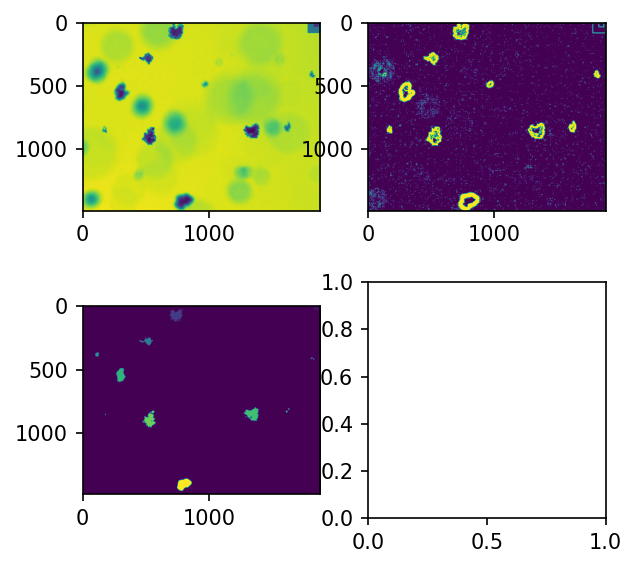

In [170]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(2,2,dpi=150, figsize=(4.5,4.5))
ax  = ax.ravel()
#ax.imshow(ims[0])
ax[0].imshow(src)
ax[1].imshow(grad)
ax[2].imshow(labels)
# for obj_idx in out: 
#     pts = out[obj_idx]["obj_contour"]
#     ax.plot(pts[:,0], pts[:,1], markersize=0.1)

In [28]:
"""
Add & Link 

The linker matches objects in a series of images.
The track formed is a list of objects. 
The linker algorithm is separate from the track management.
Simple data structures (lists, dict) are preferred to classes. 
Functions that transform the data structures are preferred to class attributes.
Start with the simple case of matching by size and distance. 
Suitable for processing a recorded video, not a live video feed.

"""
from copy import deepcopy
import numpy as np
from matplotlib import pyplot as plt

def add_obj_to_track(tracks, track_idx, frame_idx, obj): 
    obj["track_idx"] = track_idx
    tracks[(track_idx, frame_idx)] = obj

def match_obj_in_next_frame(obj, objs, 
                            dist_max_filt=True, dist_max_filt_m=200, dist_max_filt_k=1.25,
                            dist_wt=1, dist_square=True, 
                            area_wt=1, area_square=True,
                            error_threshold=1e3
                            ): 
    """ """    
    if dist_max_filt: 
        dist_max = dist_max_filt_m + obj["obj_area"]**dist_max_filt_k
        to_remove = []
        for obj_idx in objs: 
            obj_a = obj["obj_centroid"]
            obj_b = objs[obj_idx]["obj_centroid"]
            if np.linalg.norm(obj_a-obj_b) > dist_max: 
                to_remove.append(obj_idx)
        for obj_idx in to_remove: 
            objs.pop(obj_idx)
        if len(objs) == 0: 
            return None
        
    dists = np.array([np.linalg.norm(objs[obj_idx]["obj_centroid"] - obj["obj_centroid"]) for obj_idx in objs])
    areas = np.array([objs[obj_idx]["obj_area"] - obj["obj_area"] for obj_idx in objs])
    obj_idxs = np.array(list(objs))
    
    dists = dists*dist_wt
    areas = areas*area_wt
    
    if dist_square: dists = dists**2
    if area_square: areas = areas**2
    
    error = dists + areas

    idx_min = np.argmin(error)
    if error[idx_min] < error_threshold: 
        return obj_idxs[idx_min]
    else: 
        return None

def add_and_link(objs, tracks, n_frames, frame_idx_start, new_obj_idxs, next_track_idx):
    """ """ 
    new_track_idxs = list(range(next_track_idx, next_track_idx+len(new_obj_idxs)))
    tracks_idxs = new_track_idxs.copy()
    # create new track for each new obj requested in frame_idx
    for obj_idx in new_obj_idxs: 
        obj = objs[frame_idx_start][obj_idx]
        add_obj_to_track(tracks, tracks_idxs.pop(), frame_idx_start, obj)
    
    # track through n_frames
    for track_idx in progress.track(new_track_idxs, description="[green] linking objects"):     
        for frame_idx in range(frame_idx_start, frame_idx_start+n_frames-1): 
            obj = tracks[(track_idx, frame_idx)]
            obj_idx = match_obj_in_next_frame(obj, deepcopy(objs[frame_idx+1]))
            if obj_idx is None: 
                break # this track is terminated
            else: 
                add_obj_to_track(tracks, track_idx, frame_idx+1, objs[frame_idx+1][obj_idx])

def mpl_plot_tracks(im, frame_idx, tracks): 
    """ """
    f, ax = plt.subplots(1,1, dpi=150, figsize=(4.5, 4.5))
    ax.imshow(im)
    
    def _plot_single(track_idx, frame_idx, 
               show_lines=True, line_width=0.5, line_color="b", 
               show_markers=True, marker=".", marker_size=4, mc="g"): 
        """ """
        keys = [key for key in tracks if ((key[0]==track_idx) & (key[1]<=frame_idx))]
        last_marker_color = {True: "g", False: "r"}[keys[-1][1]==frame_idx]
        cents = np.array([tracks[key]["obj_centroid"] for key in keys])

        if show_markers: 
            ax.plot(cents[:-1,0], cents[:-1,1], marker=marker, markersize=2, color=mc, linestyle="None")
        
        ax.plot(cents[-1,0], cents[-1,1], marker=marker, markersize=2, color=last_marker_color, linestyle="None")
        
        if show_lines: 
            ax.plot(cents[:,0], cents[:,1], ls="-", lw=line_width, color=line_color)
    
    track_idxs = set([l[0] for l in list(tracks.keys())])
    _ = [_plot_single(track_idx, frame_idx, show_markers=False) for track_idx in track_idxs]

state.next_track_idx = 1
state.tracks = dict()

objs = state.objs
tracks = state.tracks

next_track_idx = state.next_track_idx
frame_idx_start = 10
n_frames = 80

new_obj_idxs = list(state.objs[frame_idx_start].keys())  # new objs to track in this frame: by loc in frame or user selection
add_and_link(objs, tracks, frame_idx_start, new_obj_idxs, next_track_idx)
next_track_idx = max(set([l[0] for l in list(tracks.keys())])) + 1



Output()

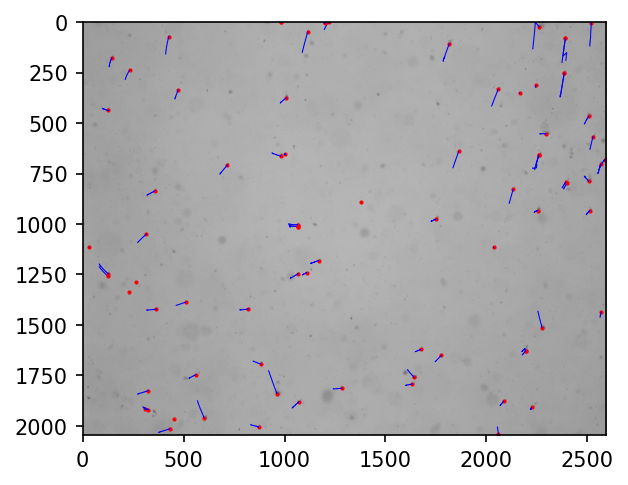

In [24]:
# make a plot of all the tracks up to current frame
frame_idx = frame_idx_start+n_frames
mpl_plot_tracks(ims[frame_idx], frame_idx, tracks)

In [25]:
max(set([1,23,4,5,66,99]))

99